In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, BasicAer, execute
from qiskit.aqua.utils.circuit_factory import CircuitFactory
from exp_a4 import A4Factory
from exp_a23 import A23Factory
from exp_a1 import A1Factory
import numpy as np
from qiskit.tools.visualization import circuit_drawer
from scipy.linalg import expm
%matplotlib inline
from qiskit.quantum_info.operators import Operator
from qiskit.aqua.circuits.gates import mct
# import FTSDFactory

In [2]:
# number of qubits n, where size of the matrix is 2**n
n = 2
t = 1
# b entry of the matrices
b_4 = 1/3
b_2 = 1/3
# k
k_vec = [2, 3]
# Number of elements in the sum (log_2 k)
#n_sum = 2**(np.ceil(np.log2(len(k_vec)))) + 1
n_sum = int(np.ceil(np.log2(len(k_vec))))
#n_sum = 3
# number of ancilla qubits for the unitary operations themselves
n_ancilla = n-1
# number of ancilla qubits for controlling the unitary operations
n_a_con = 1
# number of ancilla qubits for multi-controlled toffoli
n_toff = n_sum-2
# Hamiltonian setting
matrix_index = [0, 2]  # 0:a1, 1:a23, 2:a4
coefficient = [1.5, 1.8]  # params(e.g. theta) of each matrix

In [12]:
class FTSDFactory(CircuitFactory):
    """
    When no time is provided the simulation runs for t=1. The target qubit is the less significant one.
    """
    def __init__(self, num_target_qubits=1):
        super().__init__(num_target_qubits)

    def required_ancillas(self):
        return 0

    def required_ancillas_controlled(self):
        return 0
    
    def build(self, qc, q, q_ancillas=None, params=1):
        pass
        # qc.u3(params, -np.pi/2, np.pi/2, q[0])

    def build_controlled(self, qc, q, q_control, q_ancillas=None, t=1, kj=1, coefficient = [], matrix_index = []):
        if len(coefficient) != len(matrix_index):
            exit("Error.")
        a1 = A1Factory(n)
        a23 = A23Factory(n)
        a4 = A4Factory(n)
        
        for j in range(kj):
            for i in range(len(matrix_index)):
                if matrix_index[i] == 0:
                    a1.build_controlled(qc, qr, q_control, q_ancillas, coefficient[i]*t/kj/2)
                elif matrix_index[i]==1:
                    a23.build_controlled(qc, qr, q_control, q_ancillas, coefficient[i]*t/kj/2)
                elif matrix_index[i]==2:
                    a4.build_controlled(qc, qr, q_control, q_ancillas, coefficient[i]*t/kj/2)
                else:
                    exit("Wrong matrix index: ", i)
            for i in reversed(range(len(matrix_index))):
                if matrix_index[i] == 0:
                    a1.build_controlled(qc, qr, q_control, q_ancillas, coefficient[i]*t/kj/2)
                elif matrix_index[i]==1:
                    a23.build_controlled(qc, qr, q_control, q_ancillas, coefficient[i]*t/kj/2)
                elif matrix_index[i]==2:
                    a4.build_controlled(qc, qr, q_control, q_ancillas, coefficient[i]*t/kj/2)
                else:
                    exit("Wrong matrix index: ", i)

    def build_inverse(self, qc, q, q_ancillas=None, params=1):
        pass
        # self.build(qc, q, q_ancillas, -params)

    def build_controlled_inverse(self, qc, q, q_control, q_ancillas=None, params=1):
        self.build_controlled(qc, q, q_control, q_ancillas, -params)


In [5]:
def uni_matrix_factory(last_column):
    size = np.size(last_column)
    col = last_column.reshape((size, 1))
    a = np.zeros((size, size))

    a[:, [-1]] = col
    for i in range(size-1):
        a[:i+1, [i]] = col[:i+1]
        a[i+1, i] = - sum(col[:i+1]**2) / col[i+1]

    for i in range(size):
        a[:, i] = a[:, i] / np.sqrt(sum(a[:, i]**2))

    a = np.fliplr(a)
    a[np.isnan(a)] = 1
    return a

In [6]:
uni_matrix_factory(np.array([1,2,3,4]))

array([[ 0.18257419,  0.19518001,  0.35856858,  0.89442719],
       [ 0.36514837,  0.39036003,  0.71713717, -0.4472136 ],
       [ 0.54772256,  0.58554004, -0.5976143 ,  0.        ],
       [ 0.73029674, -0.68313005,  0.        ,  0.        ]])

In [7]:
def check_power_of_a(n, a):
    if n == 1:
        return True
    elif n % a == 0:
        n = n / a
        check_power_of_a(n, a)
    else:
        return False

In [8]:
def dec2bin(decimal_number):
    binlist = []
    for i in range(len(bin(decimal_number))-2):
        binlist.append(int(bin(decimal_number)[2+i]))
    return binlist

def permutation_control(qc, q_control_list, i):
    binlist = dec2bin(i)
    for j in range(len(binlist)):
        if binlist[j]==1:
            qc.x(q_control_list[len(binlist)-j-1])

In [9]:
def put_mct():
    if n_toff > 0:
        qc.mct(qr_sum, qrac[0], qrt)
    elif n_sum == 2:
        qc.ccx(qr_sum[0], qr_sum[1], qrac)

In [10]:
# Need to optimize when the size of k is large (this function uses double loop.)
# arxiv:1907.11679 eq.5
# return: aj: list
def get_aj_from_kj(k):
    m = len(k)
    ret = []
    for j in range(m):
        if k[j] == 0.:
            ret.append(0)
        else:
            aj = 1.
            for q in range(m):
                if j == q: continue;
                aj *= 1 - np.square(k[q] / k[j])
            ret.append(1 / aj)
    return ret;

def fill_zeros(k_vec):
    for i in range(100):
        if len(k_vec) == 2**i:
            return k_vec
        elif len(k_vec) > 2**i:
            continue
        else:
            for j in range(len(k_vec), 2**i):
                k_vec.append(0)
            break
    return k_vec
            
            

In [13]:
# TODO: for sums with more than 2 elements need to change qr[n] by the right index
#quantum register for the matrix
qr = QuantumRegister(n)
qr_sum = QuantumRegister(n_sum)
#ancilla qubits
qra = QuantumRegister(n_ancilla)
qrac = QuantumRegister(n_a_con)
cr = ClassicalRegister(n+n_sum+n_ancilla+n_a_con)
if n_toff > 0:
    qrt = QuantumRegister(n_toff)
    qc = QuantumCircuit(qr, qr_sum, qra, qrac, qrt, cr)
else:
    qc = QuantumCircuit(qr, qr_sum, qra, qrac, cr)

#create unitary operations given its last column {a_j}

#k_vec = fill_zeros(k_vec)
a_vector = get_aj_from_kj(k_vec)
a_vector = np.array(a_vector)
#a_vector =  np.arange(1, 2**n_sum+1)# a_vector has to be a power of 2
mat_A = uni_matrix_factory(a_vector)
op_A = Operator(mat_A)
op_B = Operator(mat_A.transpose())

# encode coefficient information through A matrix
qc.append(op_A, qr_sum)
qc.barrier()

for i_kj in range(len(k_vec)):
#for i in range(2**n_sum):
    permutation_control(qc, qr_sum, i_kj)
    put_mct()
    # TODO: substitute by suitable exp(iH_jt)
#     A4Factory(n).build_controlled(qc, qr, qrac[0], qra, b_4*t)
    FTSDFactory(n).build_controlled(qc, qr, qrac[0], qra, t=1, kj=k_vec[i_kj], coefficient=coefficient, matrix_index=matrix_index)
    put_mct()
    permutation_control(qc, qr_sum, i_kj)
    qc.barrier()

# invert A matrix
qc.append(op_B, qr_sum)

qc.barrier()
# measurement of qr and qr_sum
qc.measure(qr, cr[0:n])
qc.measure(qr_sum, cr[n:n+n_sum])

In [14]:
print(mat_A)
print(a_vector)
print(qr_sum)
print(op_A)

[[-0.40613847 -0.91381155]
 [ 0.91381155 -0.40613847]]
[-0.8  1.8]
QuantumRegister(1, 'q5')
Operator([[-0.40613847+0.j -0.91381155+0.j]
 [ 0.91381155+0.j -0.40613847+0.j]], input_dims=(2,), output_dims=(2,))


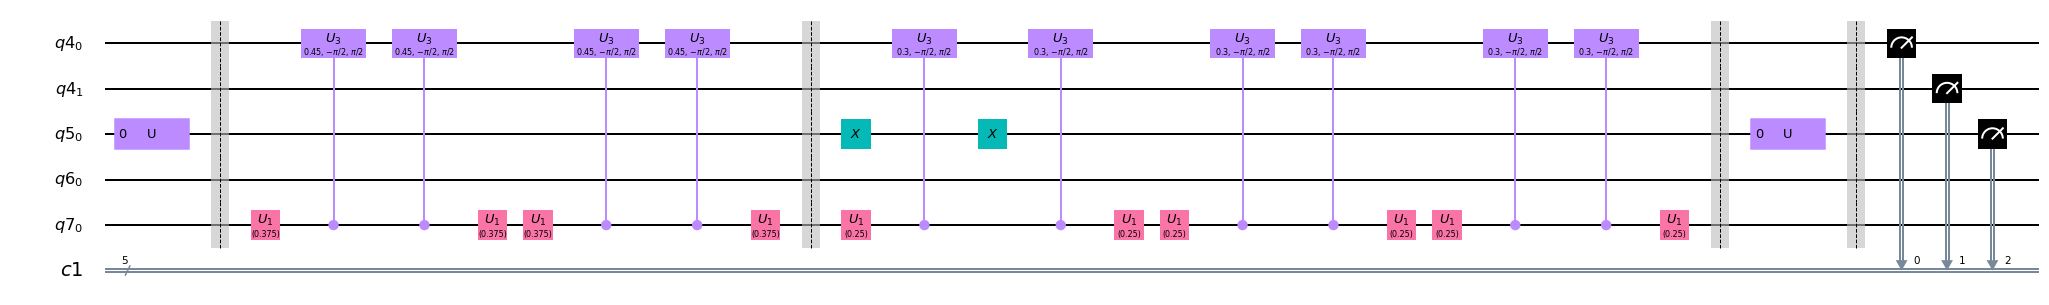

In [15]:
qc.draw(output='mpl', fold=100)

In [16]:
# Optional: send the simulation to ibm's simulator
from qiskit import IBMQ
from qiskit import BasicAer
#IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q-hub-ntu')
#backend = provider.get_backend('ibmq_qasm_simulator')
#backend = BasicAer.get_backend('qasm_simulator')

In [17]:
# Obtain vector from the circuit
backend = BasicAer.get_backend('statevector_simulator')
# Create a Quantum Program for execution 
job = execute(qc, backend)
# and store the result
result = job.result()
# Remember its an...a0qn..q0, where the a's are the ancilla
svect = result.get_statevector(qc)

# total number of qubits in the circuit
lastq = n+n_sum+n_ancilla+n_a_con

formatstr = "{0:0"+str(lastq)+"b}"
# Final vector (i.e. approximate solution of e^iHt |x>)
approx_sol = [0]*(2**n)

totalnorm= 0
for i in range(0, len(svect)):
    # Only consider the entries where the sum qubits are 0 (i.e. successful circuit)
    if formatstr.format(i)[0:n_ancilla+n_sum] == '0'*(n_ancilla+n_sum):
                totalnorm += np.real(svect[i]*np.conjugate(svect[i]))
                current_index = int(formatstr.format(i)[lastq-n:lastq][::-1], 2)
                approx_sol[current_index] += svect[i]
                
approx_sol = approx_sol/np.sqrt(totalnorm)

In [18]:
approx_sol

array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [19]:
# analytical case
H23 = np.diag(np.append(np.array([0, b_2]*((2**(n-1))-1)),0), -1) + np.diag(np.append(np.array([0, b_2]*((2**(n-1))-1)),0), 1)
H4 = np.diag(np.append(np.array([b_4, 0]*((2**(n-1))-1)),b_4), -1) + np.diag(np.append(np.array([b_4, 0]*((2**(n-1))-1)),b_4), 1)

exact_exp = expm(1j*(H23+H4)*t)

test = np.dot(exact_exp, np.append(1,[0]*((2**n)-1)))
print(test/np.linalg.norm(test))
print(approx_sol)

[ 0.94546377+0.j          0.        +0.32115795j -0.05402751+0.j
  0.        -0.00607068j]
[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
